# Predicting Subscription Churn 

**Goal**: The goal of this Jupyter tutorial is to evaluate the subscription churn using several survival methods including Kaplan-Meier estimation and Cox Proportional Hazards regression.

In [1]:
#Load Standard Libraries
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

#Set Preferred Plotting Style
sns.set_style("darkgrid")
%matplotlib inline

#Load Survival Libraries
from sksurv import column
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis

# Load Scikit-Learn Libraries
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#Load Sklearn Helpers
from sklearn.model_selection import train_test_split

In [2]:
#Import data
df = pd.read_csv('9mo_pull.csv')

## Survival Analysis

Let's experiment with some survival analysis methods. We will mainly draw upon the scikit-survival package for analysis, but a similar process could be followed using the lifelines package.

In [3]:
X = df[['source','country','tier']]

#Convert active to churn:
df['churn'] = np.where(df['active'] == 1, False ,True)
y = df[['churn','tenure']]

In [4]:
X.head()

,source,country,tier
0,referral,Germany,Platinum
1,referral,France,Platinum
2,organic,UK,Silver
3,organic,UK,Silver
4,organic,France,Gold


In [5]:
y.head()

,churn,tenure
0,True,6
1,True,1
2,True,1
3,True,4
4,True,1


In [6]:
n_censored = y.shape[0] - y["churn"].sum()
print("%.1f%% of records are censored" % (n_censored / y.shape[0] * 100))

7.5% of records are censored


The estimated survival function can be estimated by the kaplan-meier estimator. 

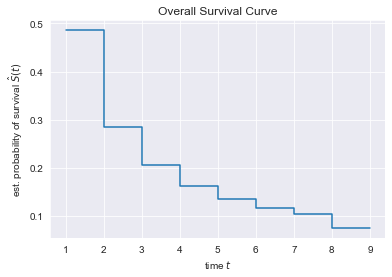

In [7]:
time, survival_prob = kaplan_meier_estimator(y["churn"], y["tenure"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title("Overall Survival Curve")
plt.show()

The survival curve above indicates that 20% of customers continue their subscription past 3 months. Next, let's look at the survival curves for the three factors in our data set: tier, lead source, and country

In [8]:
def survival_curves(X, y, feature):
    for feature_types in X[feature].value_counts().index:
        mask_treat = X[feature] == feature_types
        time_feature, survival_prob_treatment = kaplan_meier_estimator(
            y["churn"][mask_treat],
            y["tenure"][mask_treat])
    
        plt.step(time_feature, survival_prob_treatment, where="post",
                 label="Treatment = %s" % feature_types)

    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.title("Survival Curve by {}".format(feature))
    plt.legend(loc="best")
    plt.show()

Gold        59838
Silver      29472
Platinum    10634
Name: tier, dtype: int64


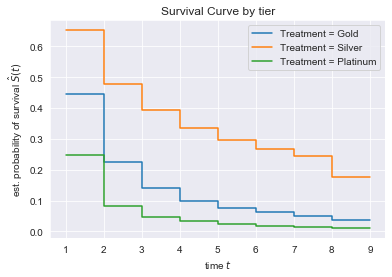

In [9]:
print(X["tier"].value_counts())
survival_curves(X,y,"tier")

organic         82836
partnerships    12200
referral         4908
Name: source, dtype: int64


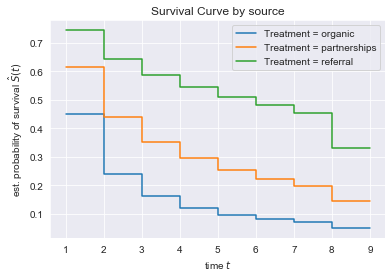

In [10]:
print(X["source"].value_counts())
survival_curves(X,y,"source")

US             18425
UK             18033
Germany        17689
France         10235
Netherlands     9693
Italy           9528
Spain           9048
Canada          7293
Name: country, dtype: int64


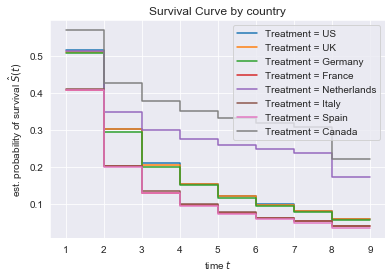

In [11]:
print(X["country"].value_counts())
survival_curves(X,y,"country")

The survival curves for the different tiers are substantially different, particularly for Silver tier customers, referral sources, and customers from the Netherlands and Canada.

Next, let's build a simple data processing and model pipeline with our data using a Cox Proportional Hazards Model.

In [12]:
#Need to convert datatypes from "object" to category
X = X.astype("category")

#Set y to a structured array
y = y.to_records(index = False)

#Split data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2,random_state = 1234)

In [13]:
X_train_encoded = OneHotEncoder().fit_transform(X_train)
X_train_encoded.head()

,source=partnerships,source=referral,country=France,country=Germany,country=Italy,country=Netherlands,country=Spain,country=UK,country=US,tier=Platinum,tier=Silver
74449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
99169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
12911,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
98183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
35772,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [14]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train_encoded, y_train)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=0)

In [23]:
pd.Series(estimator.coef_, index=X_train_encoded.columns)

source=partnerships   -0.441396
source=referral       -1.038244
country=France         0.475465
country=Germany        0.254367
country=Italy          0.476391
country=Netherlands    0.114774
country=Spain          0.487938
country=UK             0.266080
country=US             0.265185
tier=Platinum          0.282158
tier=Silver           -0.563915
dtype: float64

### Interpret coeffcients

In [24]:
prediction = estimator.predict(X_train_encoded)
result = concordance_index_censored(y_train["churn"], y_train["tenure"], prediction)
print("Training Set Concordance Index: " + str(result[0]))

Training Set Concordance Index: 0.6775762362003798


In [25]:
X_test_encoded = OneHotEncoder().fit_transform(X_test)

prediction = estimator.predict(X_test_encoded)
result = concordance_index_censored(y_test["churn"], y_test["tenure"], prediction)

print("Test Set Concordance Index: " + str(result[0]))

Test Set Concordance Index: 0.6828278833929738


Next, we can create four synthetic customers and estimate their survival curve.

In [26]:
x_new = pd.DataFrame.from_dict({
    1: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],  # Partnership, Netherlands, Silver
    2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Organic, Canada, Gold
    3: [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],  # Organic, Germany, Platinum
    4: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]}, # Referral, Canada, Silver
     columns=X_train_encoded.columns, orient='index')
x_new

,source=partnerships,source=referral,country=France,country=Germany,country=Italy,country=Netherlands,country=Spain,country=UK,country=US,tier=Platinum,tier=Silver
1,1,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,1


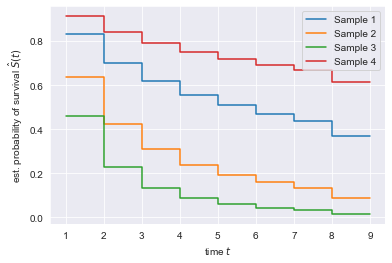

In [27]:
pred_surv = estimator.predict_survival_function(x_new)
for i, c in enumerate(pred_surv):
    plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.show()

## Feature Selection: Which Variable is Most Predictive?

In [60]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X.iloc[:, j:j+1]
        Xj = OneHotEncoder().fit_transform(Xj)
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(X_train, y_train)
pd.Series(scores, index=X_train.columns).sort_values(ascending=False)

tier       0.623296
source     0.565573
country    0.559932
dtype: float64

In [76]:
X_train_dummified = pd.get_dummies(X_train)

def fit_and_score(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X.iloc[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score(X_train_dummified, y_train)
pd.Series(scores, index = X_train_dummified.columns).sort_values(ascending=False)

tier_Silver            0.602491
source_organic         0.563125
tier_Gold              0.559379
tier_Platinum          0.543111
source_partnerships    0.532375
source_referral        0.530750
country_Canada         0.518622
country_France         0.515748
country_Spain          0.513892
country_Italy          0.513567
country_Netherlands    0.511341
country_Germany        0.496966
country_UK             0.495029
country_US             0.494763
dtype: float64

Tier is the most predictive feature, followed by source, then country. 

## Create Model Pipelines with Cross-Validation

In [36]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k = 3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'select__k': np.arange(1, X_train_encoded.shape[1] + 1),
              'model__alpha': np.arange(0,1,.1)}
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=3, iid=True)
gcv.fit(X_train, y_train)

pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)

## Concluding Remarks

Random Forest and Decision Tree algorithms perform approximately the same on the test data, with an RMSE of approximately 1.55 months. There are a few variables of importance that stand out in the figure above, which confirm our understanding gained during EDA. The Silver tier is the most important feature for determining tenure, particularly longer tenure. Organic sourcing is also important, namely non-organic sourcing is best. Two countries, the Netherlands and Canada, have the longest tenure. Final recommendations include:
* Promotion of Silver Tier above others.
* Increase marketing in the Netherlands and Canada.
* Re-visit partnership agreements.
* Develop referral incentive to increase number of referrals. 


## Next Steps

Additional parameter tuning for the Random Forest algorithm may improve predictive accuracy.